
# Fit Two Dimensional Peaks

This example illustrates how to handle two-dimensional data with lmfit.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

## Two-dimensional Gaussian
We start by considering a simple two-dimensional gaussian function, which
depends on coordinates `(x, y)`. The most general case of experimental
data will be irregularly sampled and noisy. Let's simulate some:



In [2]:
npoints = 10000
np.random.seed(2021)
x = np.random.rand(npoints)*10 - 4
y = np.random.rand(npoints)*5 - 3
z = gaussian2d(x, y, amplitude=30, centerx=2, centery=-.5, sigmax=.6, sigmay=.8)
z += 2*(np.random.rand(*z.shape)-.5)
error = np.sqrt(z+1)

To plot this, we can interpolate the data onto a grid.



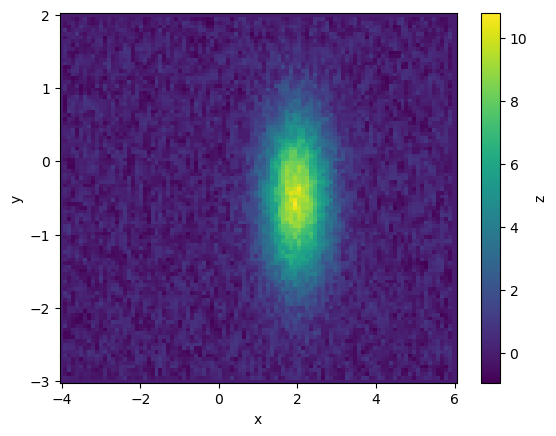

In [3]:
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                   np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)

fig, ax = plt.subplots()
art = ax.pcolor(X, Y, Z, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In this case, we can use a built-in model to fit



In [4]:
model = lmfit.models.Gaussian2dModel()
params = model.guess(z, x, y)
result = model.fit(z, x=x, y=y, params=params, weights=1/error)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 10000
    # variables        = 5
    chi-square         = 20618.1774
    reduced chi-square = 2.06284916
    Akaike info crit   = 7245.87992
    Bayesian info crit = 7281.93162
    R-squared          = 0.28378389
[[Variables]]
    amplitude:  27.4195833 +/- 0.65062974 (2.37%) (init = 16.51399)
    centerx:    1.99705425 +/- 0.01405864 (0.70%) (init = 1.940764)
    centery:   -0.49516158 +/- 0.01907800 (3.85%) (init = -0.5178641)
    sigmax:     0.54740777 +/- 0.01224965 (2.24%) (init = 1.666582)
    sigmay:     0.73300589 +/- 0.01617042 (2.21%) (init = 0.8332836)
    fwhmx:      1.28904676 +/- 0.02884573 (2.24%) == '2.3548200*sigmax'
    fwhmy:      1.72609693 +/- 0.03807842 (2.21%) == '2.3548200*sigmay'
    height:     10.8758308 +/- 0.35409534 (3.26%) == '0.1591549*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(ampli

To check the fit, we can evaluate the function on the same grid we used
before and make plots of the data, the fit and the difference between the two.



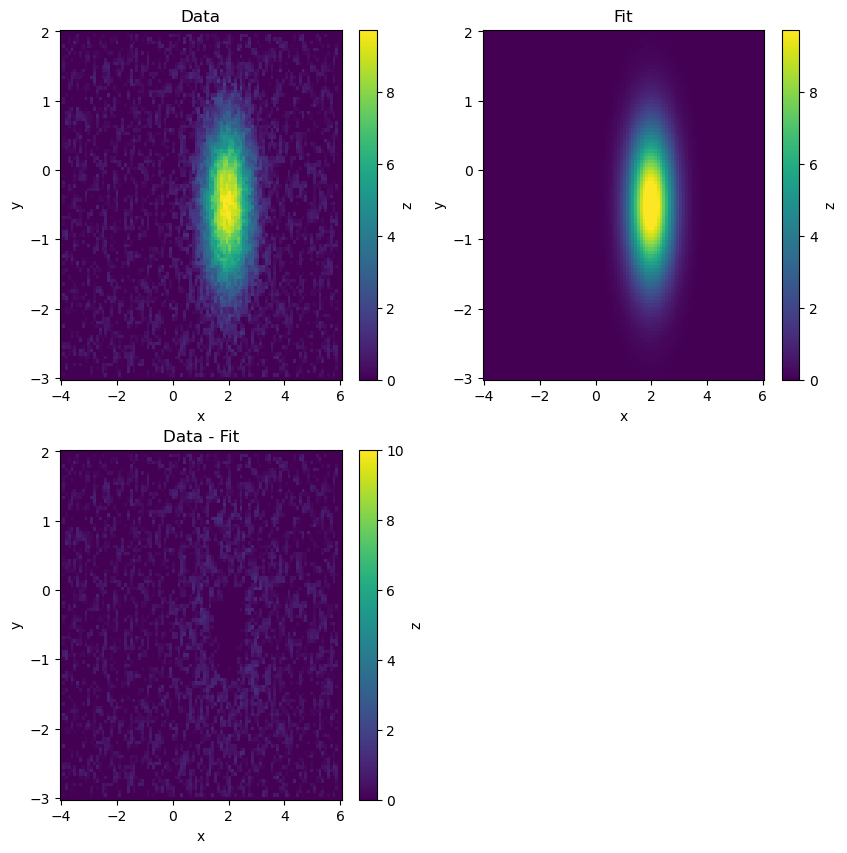

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()

## Two-dimensional off-axis Lorentzian
We now go on to show a harder example, in which the peak has a Lorentzian
profile and an off-axis anisotropic shape. This can be handled by applying a
suitable coordinate transform and then using the `lorentzian` function that
lmfit provides in the lineshapes module.



In [ ]:
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay)

Data can be simulated and plotted in the same way as we did before.



In [ ]:
npoints = 10000
x = np.random.rand(npoints)*10 - 4
y = np.random.rand(npoints)*5 - 3
z = lorentzian2d(x, y, amplitude=30, centerx=2, centery=-.5, sigmax=.6,
                 sigmay=1.2, rotation=30*np.pi/180)
z += 2*(np.random.rand(*z.shape)-.5)
error = np.sqrt(z+1)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                   np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
art = ax.pcolor(X, Y, Z, shading='auto')
plt.colorbar(art, ax=ax, label='z')
plt.show()

To fit, create a model from the function. Don't forget to tell lmfit that both
`x` and `y` are independent variables. Keep in mind that lmfit will take the
function keywords as default initial guesses in this case and that it will not
know that certain parameters only make physical sense over restricted ranges.
For example, peak widths should be positive and the rotation can be restricted
over a quarter circle.



In [ ]:
model = lmfit.Model(lorentzian2d, independent_vars=['x', 'y'])
params = model.make_params(amplitude=10, centerx=x[np.argmax(z)],
                           centery=y[np.argmax(z)])
params['rotation'].set(value=.1, min=0, max=np.pi/2)
params['sigmax'].set(value=1, min=0)
params['sigmay'].set(value=2, min=0)

result = model.fit(z, x=x, y=y, params=params, weights=1/error)
lmfit.report_fit(result)

The process of making plots to check it worked is the same as before.



In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()